In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import re
import time
import json
from src.data_analysis import web_utilities
from src.data_analysis import df_utilities
%matplotlib inline 

### Problem Overview

As Star Wars data nerds, we have a few questions about the Universe. We don’t really like wikis, but we do
love APIs, code, charts, and graphs!

We’ve seen the Star Wars API (https://swapi.co), and its data seem useful. However, it leaves us with a few
specific questions that we need answered in visual form:
    1. It seems like there is quite a variety of heights in the Star Wars Universe. Show us the distribution 
    of heights across gender, homeworld, and species.
    2. The Original Trilogy and the Prequel Trilogy both featured men in leading roles and women in supporting 
    roles, but the Sequel Trilogy features a leading woman. What is the distribution of genders across the films?
    3. Back to our difficult-to-explain interest in heights: can you find and visualize a linear regression that
    clearly explains the height of an individual? Using a programming language and/or framework of your choice, 
    write a program that gives us insight into these questions. We like visualizations (e.g. charts and graphs), 
    not tables or lists of numbers. If you have any other ideas, questions or insights from the data, we’d love 
    to see those as well!

## Navigating the API

There are a few different ways to access the API. The resource types are:
 - Film, People, Planets, Species, Starships, and Vehicles

Film will give us information about each film (title, opening crawl, director, etc.), people will give us information about a person within the Star Wars universe (name, height, eye color, etc.), and so on. Here it makes sense to focus on the "people" resource - since we're being asked very "people-centric" questions. 

In [2]:
# url = 'http://swapi.co/api/people/'
# a = web_utilities.get_json(url)

In [3]:
#a.keys()

In [4]:
# print('Next: {}'.format(a['next']), 
#       'Previous: {}'.format(a['previous']), 
#       'Count: {}'.format(a['count']), sep='\n')

In [5]:
#a['results']

This is a very nice API. By making a GET request to the root "people" url, we are given all the information we need to request all of the "people" resources.

# People Attributes
![people_attribute info](./assets/images/people_attributes.png)

There are 87 people, so we can easily load all of the People data into memory. It would be nice to put these into a Pandas DataFrame, but the data will need to be wrangled a little bit first. We can drop "url", "created", and "edited". The "films", "species", "starships", and "vehicles" attributes are returned arrays, so we'll need to figure out some way to make these into valid columns. For "films" for example, we might have a column for each movie and a value of True or False for each row, indicating if the person was present or not. 

In [6]:
column_list = ['name','birth_year','eye_color','gender','hair_color',
                'height','mass','skin_color','homeworld']

In [7]:
#from src.data_analysis import web_utilities
from src.data_analysis import df_utilities

In [8]:
# results = a['results']
# df = df_utilities.get_initial_df()
# df = df_utilities.add_to_df(df, results)

In [9]:
# df[df.columns[:12]].head()

## Writing data to csv
This takes a little while to run (because I added a delay to be courteous). I'm writing the data to a csv on my machine so that I don't have to reload it from the site over and over.

In [10]:
if not os.path.exists('./assets/dataframe.csv'):
    df = df_utilities.build_dataframe()
    df.to_csv('./assets/dataframe.csv')
else: 
    df = pd.read_csv('./assets/dataframe.csv', index_col = 0)
    print("Dataframe loaded from .csv!")

Dataframe loaded from .csv!


In [11]:
df.head()

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,https://swapi.co/api/starships/21/,https://swapi.co/api/starships/28/,https://swapi.co/api/starships/40/,https://swapi.co/api/starships/41/,https://swapi.co/api/vehicles/42/,https://swapi.co/api/vehicles/55/,https://swapi.co/api/vehicles/45/,https://swapi.co/api/vehicles/60/,https://swapi.co/api/starships/77/,https://swapi.co/api/starships/49/
0,Luke Skywalker,19BBY,blue,male,blond,172,77,fair,https://swapi.co/api/planets/1/,https://swapi.co/api/species/1/,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,112BBY,yellow,NaN,NaN,167,75,gold,https://swapi.co/api/planets/1/,https://swapi.co/api/species/2/,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,33BBY,red,NaN,NaN,96,32,"white, blue",https://swapi.co/api/planets/8/,https://swapi.co/api/species/2/,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,41.9BBY,yellow,male,none,202,136,white,https://swapi.co/api/planets/1/,https://swapi.co/api/species/1/,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,19BBY,brown,female,brown,150,49,light,https://swapi.co/api/planets/2/,https://swapi.co/api/species/1/,...,False,False,False,False,False,False,False,False,False,False


Part of what makes Pandas fast is the fact that under the hood it's making use of Numpy ndarrays. These have to be a single datatype though (bool, int, float, etc.), so if we have an array that's all integers and one string, the whole thing will be cast to Numpy's "fallback" datatype, which is "object". We want to avoid that because working with an object ndarray is VERY slow in comparison.

In [12]:
## About half of our people have unknown birth years. 
## We'll have to think carefully about whether we want to use this field.
df[df.birth_year == 'unknown'].shape[0]

44

![birth year info](./assets/images/birth_year.png)

In [13]:
## The birth years are in either "BBY" or "ABY", before or after an event in the 
## Star Wars universe. We can cast BBY values as negative floats, ABY values as positive
## floats, and "unknown" as NaN
def do_stuff(x):
    if x[-3:] == 'BBY': return -float(x[:-3])
    elif x[-3:] == 'ABY': return float(x[:-3])
    else: return np.NaN
    
def format_birth_year(df):
    return df.birth_year.apply(lambda x: do_stuff(x))

print(np.where(format_birth_year(df) > 0)[0])
# Hmm, they never use any ABY dates. I guess they're leaving the door open for 
# future information to be added (with new movies and all)

[]


# Data Visualization

The data is now in a Pandas Dataframe. This gives us a lot of useful tools. We can take advantage of some of the things that make Numpy powerful (vectorization, broadcasting, etc), while gaining a lot of convenience (labeled columns, easier to deal with missing values, etc.). 

In [14]:
def num_known(df, x):
    return np.where(df[x] != 'unknown')[0].shape[0]
def num_unknown(df, x):
    return np.where(df[x] == 'unknown')[0].shape[0]

## Unknown values
Let's get an idea of how much of our data is unknown. 

In [15]:
for i in df.columns[1:9]:
    u = num_unknown(df, i)
    print('Field: {}\t\t{} out of 87 are unknown'.format(i.ljust(10), u))

Field: birth_year		44 out of 87 are unknown
Field: eye_color 		3 out of 87 are unknown
Field: gender    		0 out of 87 are unknown
Field: hair_color		1 out of 87 are unknown
Field: height    		6 out of 87 are unknown
Field: mass      		28 out of 87 are unknown
Field: skin_color		2 out of 87 are unknown
Field: homeworld 		0 out of 87 are unknown


So it might be iffy to make conclusions using the birth_year or mass fields.

## Height distribution across gender

In [16]:
# a['results']

In [17]:
def format_col_entry(x,i,j,w):
    a = '{}: {}'.format(x,i).ljust(w-5)[:w-5]
    b = '{}: {}'.format('counts',j).ljust(w-5)[:w-5]
    return a+'\t'+b
    #return '{}: {}\tcounts: {}'.format(x, str(i).ljust(w),j)

def print_header(x, w):
    print('{} and {} count'.format(x,x))
    print('-'*72) 

def get_unique_counts(df,x):
    non_na_ind = ~df[x].isna()
    return np.unique(df[x][non_na_ind], return_counts=True)
    
def print_unique_counts(df,x,w=25,cols=2):
    print_header(x,w)
    x_vals, x_counts = get_unique_counts(df, x)
    l = [format_col_entry(x,i,j,w) for i,j in zip(x_vals, x_counts)]
    r = len(l)%cols
    if r != 0:
        l += ' '*r
    c = len(l)//cols
    col_list = [l[i:i+c] for i in range(0,len(l),c)]
    for i in range(c):
        print(*[col_list[j][i] for j in range(cols)], sep='\t|', end='\n')
    print(format_col_entry(x,'NaN',len(df[x].isna()),w))
        


print_unique_counts(df, 'gender')

gender and gender count
------------------------------------------------------------------------
gender: female      	counts: 19          	|gender: male        	counts: 62          
gender: hermaphrodit	counts: 1           	|gender: none        	counts: 2           
gender: NaN         	counts: 87          


It makes sense to ignore the hermaphrodite, n/a, and none values

In [18]:
def get_height_mask(df, g):
    return df.apply(lambda x: True if ((x.gender == g) and \
                    (x.height != 'unknown')) else False, axis = 1)
    
male_heights = df.height[get_height_mask(df, 'male')]
female_heights = df.height[get_height_mask(df, 'female')]
# male_mask = np.where(df.gender == 'male')[0]
# female_mask = np.where(df.gender == 'female')[0]
# male_heights = df.height[male_mask]
# female_heights = df.height[female_mask]

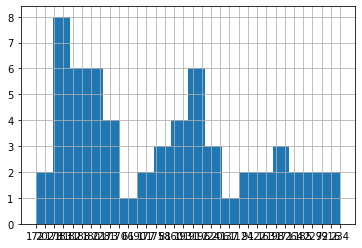

In [19]:
male_heights.hist(bins = 18)

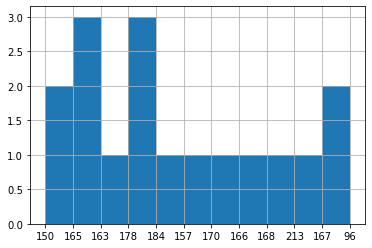

In [20]:
female_heights.hist(bins = 11)

In [21]:
## Wow, that's really not many women. I didn't realize there were so few
np.where(df.gender=='female')[0].shape[0]

19

In [22]:
df = df_utilities.cleanup(df)
df.head()

planets JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!


,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,NaN,NaN,167,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,NaN,NaN,96,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [23]:
for i in np.arange(9,15,1):
    print(df.columns[i])


species
The Empire Strikes Back
Revenge of the Sith
Return of the Jedi
A New Hope
The Force Awakens


In [24]:
df.head()

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,NaN,NaN,167,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,NaN,NaN,96,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [25]:
df_utilities.urls_to_names(df).head()

films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!


,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,NaN,NaN,167,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,NaN,NaN,96,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [26]:
# Wow, everyone has to be SO special with their homeworlds.
print_unique_counts(df,'homeworld')

homeworld and homeworld count
------------------------------------------------------------------------
homeworld: Alderaan 	counts: 3           	|homeworld: Mon Cala 	counts: 1           
homeworld: Aleen Min	counts: 1           	|homeworld: Muunilins	counts: 1           
homeworld: Bespin   	counts: 1           	|homeworld: Naboo    	counts: 11          
homeworld: Bestine I	counts: 1           	|homeworld: Nal Hutta	counts: 1           
homeworld: Cato Neim	counts: 1           	|homeworld: Ojom     	counts: 1           
homeworld: Cerea    	counts: 1           	|homeworld: Quermia  	counts: 1           
homeworld: Champala 	counts: 1           	|homeworld: Rodia    	counts: 1           
homeworld: Chandrila	counts: 1           	|homeworld: Ryloth   	counts: 2           
homeworld: Concord D	counts: 1           	|homeworld: Serenno  	counts: 1           
homeworld: Corellia 	counts: 2           	|homeworld: Shili    	counts: 1           
homeworld: Coruscant	counts: 3           	|home

In [27]:
worlds,world_counts = np.unique(df.homeworld, return_counts=True)
populous_worlds = worlds[np.where(world_counts>2)]
populous_worlds

array(['Alderaan', 'Coruscant', 'Kamino', 'Naboo', 'Tatooine', 'unknown'],
      dtype=object)

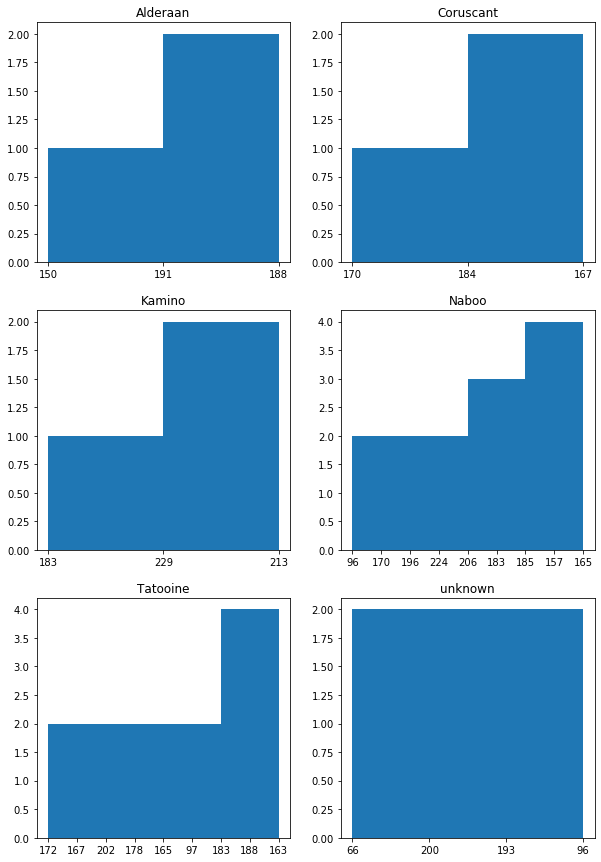

In [28]:
def get_height_mask(df, col1, col2, val):
    return df.apply(lambda x: True if ((x[col1] == val) and \
                    (x[col2] != 'unknown')) else False, axis = 1)

fig = plt.figure(figsize=(10,15))
ax_list = []
hmax = 0
hmin = 500
height_list = []
for i in range(len(populous_worlds)):
    world = populous_worlds[i]
    windex = get_height_mask(df, 'homeworld','height', world)
    height_list.append(list(df.height[windex]))
    for j in df.height[windex]:
        n = int(j)
        if n > hmax: hmax = n
        if n < hmin: hmin = n
            
for h, w, i in zip(height_list, populous_worlds, range(len(populous_worlds))):
    hbins = np.array([hmin]+[int(j) for j in h]+[hmax])
    ax_list.append(fig.add_subplot(3,2,i+1))
    #ax_list[-1].set_xlim([60,230])
    ax_list[-1].hist(h, bins='sqrt', histtype='stepfilled')
    ax_list[-1].set_title(populous_worlds[i])


# for i in range(len(populous_worlds)):
#     world = populous_worlds[i]
#     windex = get_height_mask(df, 'homeworld','height', world)
#     ax = fig.add_subplot(3,2,i+1)
#     ax.hist(df.height[windex])
#     ax.set_title(populous_worlds[i])
#     height_list.append(list(df.height[windex]))
#     for j in df.height[windex]:
#         n = int(j)
#         if n > hmax: hmax = n
#         if n < hmin: hmin = n

In [29]:
for h,w in zip(height_list, populous_worlds):
    print(w)
    print(h)

Alderaan
['150', '191', '188']
Coruscant
['170', '184', '167']
Kamino
['183', '229', '213']
Naboo
['96', '170', '196', '224', '206', '183', '183', '185', '157', '165', '165']
Tatooine
['172', '167', '202', '178', '165', '97', '183', '188', '163', '183']
unknown
['66', '200', '193', '96']


In [30]:
print_unique_counts(df,'species')

species and species count
------------------------------------------------------------------------
species: Aleena     	counts: 1           	|species: Nautolan   	counts: 1           
species: Besalisk   	counts: 1           	|species: Neimodian  	counts: 1           
species: Cerean     	counts: 1           	|species: Pau'an     	counts: 1           
species: Chagrian   	counts: 1           	|species: Quermian   	counts: 1           
species: Clawdite   	counts: 1           	|species: Rodian     	counts: 1           
species: Droid      	counts: 5           	|species: Skakoan    	counts: 1           
species: Dug        	counts: 1           	|species: Sullustan  	counts: 1           
species: Ewok       	counts: 1           	|species: Tholothian 	counts: 1           
species: Geonosian  	counts: 1           	|species: Togruta    	counts: 1           
species: Gungan     	counts: 3           	|species: Toong      	counts: 1           
species: Human      	counts: 35          	|species:

In [31]:
species,species_count = get_unique_counts(df,'species')
common_species = species[np.where(species_count>2)]
common_species

array(['Droid', 'Gungan', 'Human'], dtype=object)

96 202


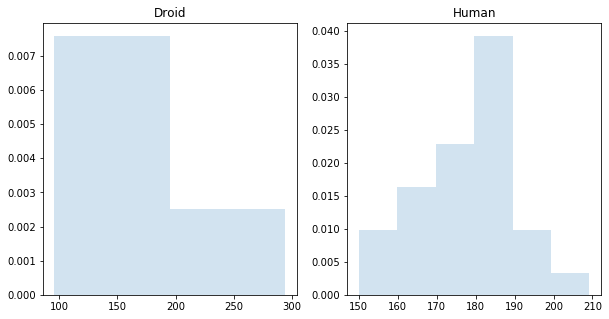

In [69]:
from astropy.visualization import hist


def plot_cols(quant_list, col1_vals, graph_width, bin_val, htype, title_str):
    clen = len(col1_vals)
    ax_list = []
    plot_height = clen // 2 + clen % 2
    fig = plt.figure(figsize=(graph_width,plot_height*5))
    for v1, v2, i in zip(quant_list, col1_vals, range(clen)):
        ax_list.append(fig.add_subplot(plot_height,2,i+1))
        n, bins, patches = hist(v1, bins=bin_val, ax=ax_list[-1], 
                                histtype=htype, alpha=0.2, density=True)
        ax_list[-1].set_title(title_str.format(col1_vals[i]))
            
            
def plot_df_hist(df, col1, col1_vals, col2='height', graph_width=10,
                     plot_type='cols', bin_val='freedman', 
                     htype='stepfilled', title_str='{}'):
    clen = len(col1_vals)
    ax_list = []
    hmax = 0
    hmin = 500
    quant_list = []
    for i in range(clen):
        x = col1_vals[i]
        quant_mask = get_height_mask(df, col1, col2, x)
        quant_list.append([float(i) for i in df[col2][quant_mask]])
        for j in df[col2][quant_mask]:
            n = int(j)
            if n > hmax: hmax = n
            if n < hmin: hmin = n
    print(hmin,hmax)
    if plot_type == 'cols':
        plot_cols(quant_list, col1_vals, graph_width, bin_val, htype, title_str)
#         plot_height = clen // 2 + clen % 2
#         fig = plt.figure(figsize=(graph_width,plot_height*5))
#         for v1, v2, i in zip(quant_list, col1_vals, range(clen)):
#             ax_list.append(fig.add_subplot(plot_height,2,i+1))
#             #ax_list[-1].hist(v1, bins=bin_val, histtype=htype)
#             n, bins, patches = hist(v1, bins='blocks', ax=ax_list[-1], 
#                                     histtype='stepfilled', alpha=0.2, density=True)
#             ax_list[-1].set_title(title_str.format(col1_vals[i]))
    elif plot_type == 'style_test':
        pass
    else:
        fig, ax = plt.subplots(figsize=(graph_width,graph_width))
        for v1, v2, i in zip(quant_list, col1_vals, range(clen)):
            #n, bins, patches = ax.hist(v1, bins=bin_val, histtype=htype, alpha=.3)
            hist(v1, bins='blocks', ax=ax, histtype='stepfilled',
                 alpha=0.2, density=True)
            q = [float(j) for j in v1]
            mu, std = norm.fit(q)
            y = norm.pdf(bins, mu, std)
            l = ax.plot(bins, y*200, 'r--', linewidth=2)
plot_df_hist(df,'species',['Droid','Human'])

In [67]:
# plot_in_two_cols(df,'species',common_species, plot_type='single')

